# HW 2
## Miles Lucas
### Stat 444 - Iowa State University

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
plt.style.use('seaborn')

## Problem 1

In [2]:
data = pd.read_csv('marathontimes.csv', index_col=0)
time = data['time']

In [3]:
data.describe()

,time
count,20.000000
mean,277.600000
std,49.538289
min,182.000000
25%,247.500000
50%,279.500000
75%,296.000000
max,365.000000


These times represent the finish times for different runners. We assume each finish time, $y_i$ to be distributed normally like $y_i ~ N(\mu, \sigma^2)$. Without assuming a fixed mean or variance, I will find the conjugate distributions and model the two parameters. 

The defacto conjugate prior for such a distribution is the Normal-inverse gamma with parameters $\mu_0$, $\nu$, $\alpha$, and $\beta$. It has a pdf of

$$
\frac{\sqrt{\lambda}}{\sqrt{2\pi}} \frac{\beta^{\alpha}}{\Gamma (\alpha)} \left( \frac{1}{\sigma^2} \right)^{\alpha+1/2} e^{-\frac{2\beta + \lambda(x-\mu)^2}{2\sigma^2}}
$$

For the priors, I will choose $\mu_0$ close to an average marathon runner of 270 minutes (http://time.com/5007486/new-york-city-marathon-runners-slow/), $\nu$ to 1 for uninformivitey, and $\beta$ and $\alpha$ such that $\beta/\alpha$ is close to a variance of 1000 minutes ($\sigma$ about 30 minutes). I can scale everything except $\mu_0$ to change confidence, as I will show after this initial modeling.

In [4]:
mu0_prior = 240
nu_prior = [1, 10, 100]
a_prior = [.5, 2, 200]
b_prior = [500, 2000, 200000]

s2_prior = [stats.invgamma(a, scale=b) for a, b in zip(a_prior, b_prior)]
mu_prior = [stats.norm(mu0_prior, scale=s2.rvs(10000) / nu) for s2, nu in zip(s2_prior, nu_prior)]

To update my priors, I use the following changes:
$$\mu_0' = \frac{\nu \mu_0 + n \bar{x}}{\nu + n}$$
$$ \nu' = \nu + n $$
$$ \alpha' = \alpha+\frac{n}{2} $$
$$ \beta' = \beta + \frac{1}{2} \sum^n_{i=1}{(x_i - \bar{x})^2} + \frac{n\nu}{\nu + n} \frac{(\bar{x} - \mu_0)^2}{2} $$

In [5]:
mu0_post = [(nu * mu0_prior + time.count() * time.mean()) / (nu + time.count()) for nu in nu_prior]
nu_post = [nu + time.count() for nu in nu_prior]
a_post = [a + time.count() / 2 for a in a_prior]
b_post = [b + 1/2 * np.sum((time - time.mean())**2) + \
    (time.count() * nu * (time.mean() - mu0_prior)**2) / (2* (nu + time.count())) \
          for b, nu in zip(b_prior, nu_prior)]


s2_post = [stats.invgamma(a, scale=b) for a, b in zip(a_post, b_post)]
mu_post = [stats.norm(mu0, scale=s2.rvs(10000) / nu) for mu0, s2, nu in zip(mu0_post, s2_post, nu_post)]

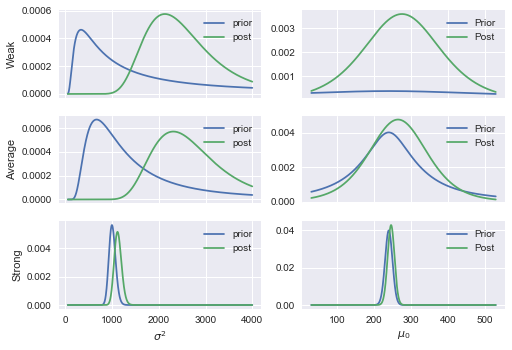

In [6]:
# Forgive me, matplotlib can get pretty verbose the more customization you want
plt.figure(figsize=(10,10))

plt.close('all')

row_titles = ['Weak', 'Average', 'Strong']
_, rows = plt.subplots(3, 2, sharex='col')
rows[2][0].set_xlabel(r'$\sigma^2$')
rows[2][1].set_xlabel(r'$\mu_0$')
for s2_pri, mu_pri, s2_po, mu_po, row, row_title in zip(s2_prior, mu_prior, s2_post, mu_post, rows, row_titles):
    row[0].set_ylabel(row_title)
    
    i_s2 = np.linspace(50, 4000, 1000)
    row[0].plot(i_s2, s2_pri.pdf(i_s2), label='prior')
    row[0].plot(i_s2, s2_po.pdf(i_s2), label='post')
    row[0].legend()


    i_mu = np.linspace(30, 530, 1000)
    mu_prior_samples = [mu_pri.pdf(i).mean() for i in i_mu]
    mu_post_samples = [mu_po.pdf(i).mean() for i in i_mu]
    row[1].plot(i_mu, mu_prior_samples, label='Prior')
    row[1].plot(i_mu, mu_post_samples, label='Post')
    row[1].legend()        

I can say that the change in prior strengths is very clear in all examples. For our weak prior, both parameters have very wide tails and are not very imformative. I chose the average to be seemingly appropriate for the data. The strong prior shows almost no change in the variance and only a slight slimming on the mean. 

## Problem 2

In [7]:
data = pd.read_csv('../hw1/footballscores.csv', index_col=0)

In [8]:
data['outcome'] = data.favorite - data.underdog
data['diff'] = data.outcome - data.spread
diff = data['diff']
diff.describe()

count    672.000000
mean       0.069940
std       13.859994
min      -47.500000
25%       -8.500000
50%       -0.500000
75%        9.000000
max       39.500000
Name: diff, dtype: float64

In [12]:
from scipy import interpolate

def marg_s2(y):
    v = len(y) - 1
    t2 = np.var(y)
    return stats.invgamma(v/2, scale=v*t2/2)
    
    
def marg_u(u, s2, y, mu0, tau20):
    n = len(y)
    un = (mu0/tau20 + n*np.mean(y) / s2) / (1/tau20 + n/s2)
    tn2 = 1 / (1/tau20 + n / s2)
    return [stats.norm.pdf(ui, un, scale=np.sqrt(tn2)).mean() for ui in u]
    

In [13]:
mu0 = 0
tau0 = 4

x_s2 = np.linspace(150, 250, 1000)
pdf_s2 = marg_s2(diff).pdf(x_s2)
s2_samples = marg_s2(diff).rvs(10000)
x_mu = np.linspace(-2, 2, 100)
pdf_mu = marg_u(x_mu, s2_samples, diff, mu0, tau0)

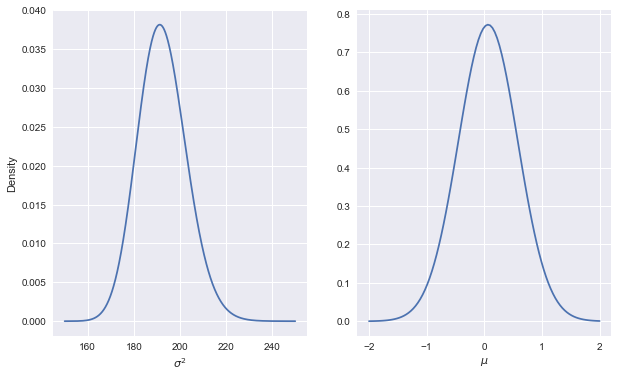

In [14]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.xlabel(r'$\sigma^2$')
plt.ylabel('Density')
plt.plot(x_s2, pdf_s2)

plt.subplot(122)
plt.xlabel(r'$\mu$')
plt.plot(x_mu, pdf_mu);

### Part 2

In [15]:
def marg_s2(s2, y, mu0, tau20, nu0, s20):
    n = len(y)
    mun = (mu0/tau20 + n*np.mean(y) / s2) / (1/tau20 + n/s2)
    tn2 = 1 / (1/tau20 + n / s2)
    
    p_mu = stats.norm.pdf(mun, mu0, scale=np.sqrt(tau0))
    p_s2 = stats.invgamma.pdf(s2, nu0/2, scale=nu0*s20/2)
    
    like = np.sum([stats.norm.pdf(yi, mun, scale=s2) for yi in y])
    
    pdf = np.sqrt(tn2) * p_mu * p_s2 * like
    return pdf


def draw_cdf(x, pdf, n=10000):
    ''' Gets a random sample using cdf method '''
    cdf =  np.cumsum(pdf) / np.sum(pdf)
    inv_cdf = interpolate.interp1d(cdf, x)    
    return inv_cdf(np.random.rand(n))

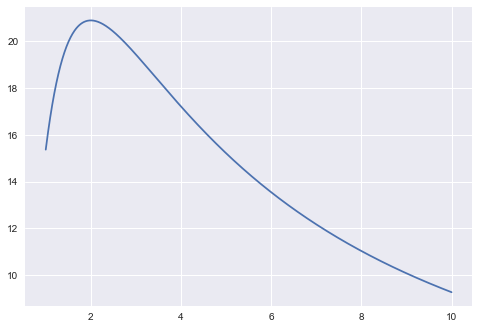

In [19]:
i_mu = np.linspace(-2, 2, 1000)
i_s2 = np.linspace (1, 10, 1000)

pdf_s2 = marg_s2(i_s2, diff, 0, 4, 1, 4)
plt.plot(i_s2, pdf_s2)
# s2_samples = draw_cdf(i_s2, pdf_s2)
# res = joint_pdf(muv, s2v, mu0, tau0, 600, 160)

Text(29.125,0.5,'$\\sigma^2$')

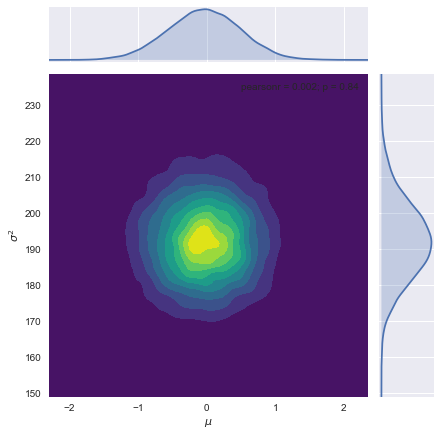

In [33]:
from seaborn import jointplot

g = jointplot(mu_samples, s2_samples, cmap='viridis', kind='kde')
g.ax_joint.set_xlabel(r'$\mu$')
g.ax_joint.set_ylabel(r'$\sigma^2$')

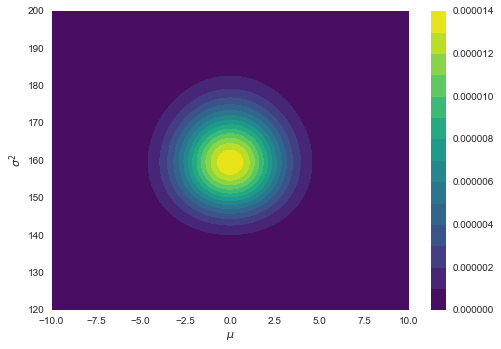

In [69]:
scaled = res / np.sum(res)
plt.contourf(scaled, 15, cmap='viridis', origin='lower', extent=(-10, 10, 120, 200))
plt.ylabel(r'$\sigma^2$')
plt.xlabel(r'$\mu$')
plt.colorbar()